In [1]:
%%capture
!rm -rf data/*
!unzip data.zip -d data/
!pip install --no-cache-dir pyldavis
from datascience import *
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pyLDAvis
import pyLDAvis.sklearn
import pickle
%matplotlib inline

# Topic Modeling in Python

In Lisa Rhody's article, "Topic Modeling and Figurative Language", she uses LDA topic modeling to look at ekphrasis poetry. She argues that ekphrasis poetry is particulary well-suited to an LDA analysis because of the assumption of a previously existing set of topics. She's able to extract a number of topics, each constituted of a set of words and probabilities. While we don't have Rhody's corpus, we can use this technique on any large text corpus. We'll use a corpus of novels curated by Andrew Piper.

---

## Corpus Description
We'll look at an English-language subset of Andrew Piper's novel corpus, totaling 150 novels by British and American authors spanning the years 1771-1930. These texts are each in a separate plaintext file in our `data` folder. Metadata is contained in a spreadsheet distributed with the novel files by the [txtLAB](https://txtlab.org/) at McGill.

The metadata provided describes the corpus that exists as `.txt` files. So let's first read in the metadata:

In [2]:
metadata_tb = Table.read_table('data/txtlab_Novel150_English.csv')
metadata_tb.show(5)

filename,id,language,date,author,title,gender,person,length
"EN_1771_Mackenzie,Henry_TheManofFeeling_Novel.txt",151,English,1771,"Mackenzie,Henry",TheManofFeeling,male,first,36458
"EN_1771_Smollett,Tobias_TheExpedictionofHenryClinker_Nov ...",152,English,1771,"Smollett,Tobias",TheExpedictionofHenryClinker,male,first,148261
"EN_1778_Burney,Fanny_Evelina_Novel.txt",153,English,1778,"Burney,Fanny",Evelina,female,first,154168
"EN_1782_Burney,Fanny_Cecilia_Novel.txt",154,English,1782,"Burney,Fanny",Cecilia,female,third,328981
"EN_1786_Beckford,William_Vathek_Novel.txt",155,English,1786,"Beckford,William",Vathek,male,third,36077


Before we go anywhere, let's randomly shuffle the rows so that we don't have them ordered by dates or anything else:

In [3]:
np.random.seed(0)
metadata_tb = Table.from_df(metadata_tb.to_df().sample(frac=1))
metadata_tb.show(5)

filename,id,language,date,author,title,gender,person,length
"EN_1900_Dreiser,Theodore_SisterCarrie_Novel.txt",265,English,1900,"Dreiser,Theodore",SisterCarrie,male,third,156048
"EN_1853_Stowe,HarrietBeecher_UncleTom'sCabin_Novel.txt",213,English,1853,"Stowe,HarrietBeecher",UncleTom'sCabin,female,third,180498
"EN_1820_Scott,Walter_Ivanhoe_Novel.txt",184,English,1820,"Scott,Walter",Ivanhoe,male,third,175069
"EN_1895_Crane,Stephen_TheRedBadgeofCourage_Novel.txt",258,English,1895,"Crane,Stephen",TheRedBadgeofCourage,male,third,46049
"EN_1794_Godwin,William_CalebWilliams_Novel.txt",158,English,1794,"Godwin,William",CalebWilliams,male,first,143832


We can see the column variables we have in the metadata with the `.labels` attribute:

In [4]:
metadata_tb.labels

('filename',
 'id',
 'language',
 'date',
 'author',
 'title',
 'gender',
 'person',
 'length')

To clarify:
<ol><li>`filename`: Name of file on disk</li>
<li>`id`: Unique ID in Piper corpus</li>
<li>`language`: Language of novel</li>
<li>`date`: Initial publication date</li>
<li>`author`: Author's name </li>
<li>`title`: Title of novel</li>
<li>`gender`: Authorial gender</li>
<li>`person`: Textual perspective</li>
<li>`length`: Number of tokens in novel</li></ol>

We see a list of `filename`s in the table, these map into a folder we have called `txtlab_Novel150_English`:

In [5]:
!ls data/txtlab_Novel150_English/

EN_1771_Mackenzie,Henry_TheManofFeeling_Novel.txt
EN_1771_Smollett,Tobias_TheExpedictionofHenryClinker_Novel.txt
EN_1778_Burney,Fanny_Evelina_Novel.txt
EN_1782_Burney,Fanny_Cecilia_Novel.txt
EN_1786_Beckford,William_Vathek_Novel.txt
EN_1788_Wollstonecraft,Mary_Mary_Novel.txt
EN_1790_Radcliffe,Ann_ASicilianRomance_Novel.txt
EN_1794_Godwin,William_CalebWilliams_Novel.txt
EN_1794_Radcliffe,Ann_TheMysteriesofUdolpho_Novel.txt
EN_1794_Rowson,Susanna_CharlotteTemple_Novel.txt
EN_1795_Lewis,Matthew_TheMonk_Novel.txt
EN_1796_Bonhote,Elizabeth_BungayCastle_Novel.txt
EN_1796_Burney,Fanny_Camilla_Novel.txt
EN_1796_Hays,Mary_EmmaCourtney_Novel.txt
EN_1797_Foster,HannahWebster_TheCoquette_Novel.txt
EN_1798_Brown,CharlesBrockden_Wieland_Novel.txt
EN_1798_Wollstonecraft,Mary_Maria_Novel.txt
EN_1799_Brown,CharlesBrockden_ArthurMervyn_Novel.txt
EN_1800_Edgeworth,Maria_CastleRackrent_Novel.txt
EN_1801_Edgeworth,Maria_Belinda_Novel.txt
EN_1804_Opie,Amelia_AdelineMowbray_Novel.txt
EN_1805_Lewis,Matthew_Th

We can then read in the full text for each novel by iterating through the column, reading each file and appending the string to our `novel_list`:

In [6]:
# create empty list, entries will be list of tokens from each novel
novel_list = []

# iterate through filenames in metadata table
for filename in metadata_tb['filename']:
    
    # read in novel text as single string
    with open('data/txtlab_Novel150_English/'+filename, 'r') as f:
        novel = f.read()
    
    # clean up (no titles)
    toks = novel.split()  # split to tokens
    toks = [t for t in toks if not t.istitle() and not t.isupper()]  # quick & dirty no titles/proper nouns
    novel = ' '.join(toks)  # join to single string
    
    # add string
    novel_list.append(novel)

Let's double check they all came through:

In [7]:
len(novel_list)

150

And look at the first 200 characters of the fourth novel:

In [8]:
metadata_tb['author'][3], metadata_tb['title'][3], novel_list[3][:200]

('Crane,Stephen',
 'TheRedBadgeofCourage',
 '1 cold passed reluctantly from the earth, and the retiring fogs revealed an army stretched out on the hills, resting. the landscape changed from brown to green, the army awakened, and began to tremble')

---

## Document Term Matrix

Now we need to make a document term matrix, just as we have in the past two classes. We can pull in our `CountVectorizer` from `sklearn` again to create our dtm: 

In [9]:
from sklearn.feature_extraction.text import CountVectorizer

While you may not have seen the importance of `max_features`, `max_df` and `min_df` before, for topic modeling this is extremely important, because otherwise your topics will not be super coherent.

Let's start out with this:

- `max_features` = 5000  (i.e. only include 5000 tokens in our dtm)
- `max_df` = .8  (i.e. don't keep any tokens that appear in > 80% of the documents)
- `min_df` = 5  (i.e. only keep the token if it appears in > 5 documents)

We'll add in a `stop_words='english'` too, which automatically uses its own stopwords list to remove from our dtm:

In [10]:
cv = CountVectorizer(max_features=5000, stop_words='english', max_df=0.80, min_df=5)

As with most machine learning approaches, to validate your model you need training and testing partitions. Since we don't have any labels (topic modeling is *unsupervised* machine learning), we just need to do this for the novel strings:

In [11]:
train = novel_list[:120]
test = novel_list[120:]

Now we can use our `cv` to `fit_transform` our training list of novels (strings!):

In [12]:
dtm = cv.fit_transform(train)

To get our words back out we'll use the method `get_feature_names()`

In [14]:
dtm_feature_names = cv.get_feature_names()
dtm_feature_names[:10]

['abandon',
 'abandoned',
 'abbey',
 'abhorrence',
 'abide',
 'abilities',
 'ability',
 'abode',
 'abominable',
 'abrupt']

We can double check that our feature limit was enforced by calling `len` on the `dtm_feature_names`:

In [15]:
len(dtm_feature_names)

5000

We can throw our dtm into a `Table` like we have before too:

In [16]:
dtm_tb = Table(dtm_feature_names).with_rows(dtm.toarray())
dtm_tb.show(5)

---

## Topic Modeling

### [Latent Dirichlet Allocation (LDA)](https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation) Models
LDA reflects an intuition that words in a text are not merely chosen at random but are drawn from underlying concepts (the so-called "latent variables"). The goal of LDA is to look across many texts in order to reverse engineer these concepts by finding words that tend to cluster with one another. For this reason, LDA has been referred to as "the mother of all word collocation techniques."

`sklearn` has the `LatentDirichletAllocation` function:

In [17]:
from sklearn.decomposition import LatentDirichletAllocation

Let's check the doc string:

In [18]:
LatentDirichletAllocation?

Importantly, we'll note:
<li>`n_components`: This is the number of topics. Choosing this is the art of Topic Modeling </li>
<li>`max_iter`: TM initially uses random distribution, and iteratively tweaks model </li>

Let's just say we'll look for 10 topics. We'll do a `max_iter` of 5. Generally, the higher `max_iter` volume the better opportunity to the model has to accurately tune, but it also takes much longer.

In [19]:
lda = LatentDirichletAllocation(n_components=10, max_iter=5)

Before we `fit` the model, we need to remember that with a lot of these probabilistic models random number generators are used to star the algorithm. If we want our results to be reproducible, we need to set the random seed of the math library we use, in this case `numpy`:

In [20]:
np.random.seed(0)

Now we just `fit` the model, as we've done with all `sklearn` models! This may take a while, a lot is going on:

In [21]:
lda_model = lda.fit(dtm)

/Users/chench/anaconda/lib/python3.5/site-packages/sklearn/decomposition/online_lda.py:532: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)


### Evaluation

One measure of the model's fit is [perplexity](https://en.wikipedia.org/wiki/Perplexity#Perplexity_of_a_probability_model), with which we can judge how well the model fits the data. We need to call this on our `test` portion after it's been transformed into a dtm:

In [22]:
lda_model.perplexity(cv.transform(test))

5201.6432940071818

***NOTE***: Currently `sklearn`s perplexity algorithm is [broken](https://github.com/scikit-learn/scikit-learn/issues/6777).

The lower the perplexity, the better the fit of the model. So one way to get the optimal number of topics would be to loop through several numbers of topics and minimize the perplexity value.

Unfortunately, it has been shown time and again that minimizing perplexity does not actually separate topics into coherent groups that humans would.

### Choosing the best model

Since traditional metrics of evaluating a model's accuracy have not proven to conform to human understanding, a new appraoch was developed by [David Minmo in 2011](http://dirichlet.net/pdf/mimno11optimizing.pdf).

> this score measures how much, within the words used to describe a topic, a common word is in average a good predictor for a less common word. ([More on topic coherency](http://qpleple.com/topic-coherence-to-evaluate-topic-models/).)

Here we look for the highest value. This algorithm has only been implemented in the Python `gensim` library. I ran the following code for you on a remote server because it takes a while!

---

```python
import pickle
from joblib import Parallel, delayed
import multiprocessing


def try_topic_number(i):
    lda_model = gensim.models.LdaModel(
        corpus,
        num_topics=i,
        id2word=dictionary,
        iterations=1000,
        alpha='auto',
        passes=4)

    cm = gensim.models.CoherenceModel(
        model=lda_model,
        corpus=corpus,
        dictionary=dictionary,
        coherence='u_mass')

    return cm.get_coherence()


if __name__ == '__main__':

    num_cores = multiprocessing.cpu_count()

    results = Parallel(n_jobs=num_cores)(delayed(try_topic_number)(i)
                                         for i in try_topic_n)

    pickle.dump(results, open('scores.pkl', 'wb'))
```

---

You can see above I've dumped the coherence scores into a binary `pickle` file. A `pickle` is simply any Python object that has been saved to a binary file. We can `load` these in too:

In [23]:
try_topic_n = list(range(5,200,2))
scores = pickle.load(open('scripts/scores.pkl', 'rb'))
list(zip(try_topic_n, scores))

[(5, -1.0719929991318369),
 (7, -0.96332378833297394),
 (9, -1.0370206116730427),
 (11, -0.9391420508605669),
 (13, -0.89941919629993672),
 (15, -0.97948998912659335),
 (17, -0.91916766531351723),
 (19, -0.90498737828676379),
 (21, -0.94107971748945507),
 (23, -0.91727178335847159),
 (25, -0.94560202854227282),
 (27, -0.94721997500437649),
 (29, -0.93943916769500091),
 (31, -0.94078558004436297),
 (33, -0.95568210386623209),
 (35, -0.97168223052159419),
 (37, -0.95621895351631225),
 (39, -0.96524311591964762),
 (41, -0.94611608471546926),
 (43, -0.94697199863616643),
 (45, -0.93911588662731871),
 (47, -0.9498111580639399),
 (49, -0.95470584233581701),
 (51, -0.94337074894135131),
 (53, -0.95659529167559731),
 (55, -0.95964640866303286),
 (57, -0.95353739781735525),
 (59, -0.96554670690867095),
 (61, -0.96413249399173662),
 (63, -0.9597071349712456),
 (65, -0.95322075064367251),
 (67, -0.97453921826460621),
 (69, -0.95904498451803188),
 (71, -0.95284091993987274),
 (73, -0.9467063411643

Let's plot these results:

Text(0,0.5,'coherence score')

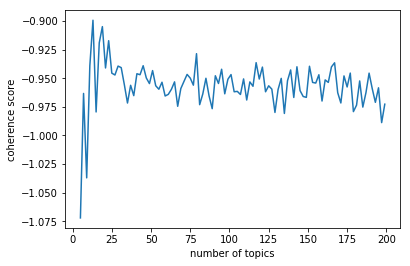

In [26]:
plt.plot(try_topic_n, [x for x in scores])
plt.xlabel('number of topics')
plt.ylabel('coherence score')

`numpy` has a handy `argmax` or `argmin` function that returns the index of the highest or lowest value in an array:

In [27]:
np.argmax(scores)

4

Then we can just index our topic numbers to get the corresponding number of topics with the highest coherency:

In [29]:
try_topic_n[np.argmax(scores)]

13

I've retrained the model for 13 topics and exported as below (note the `max_iter=1000` takes a long time, so I've pickled the model again):

---

```python
lda = LatentDirichletAllocation(n_components=13, max_iter=1000)
lda_model = lda.fit(dtm)

pickle.dump((lda, lda_model, dtm, cv), open('13-topics-2.pkl', 'wb'))
```

---

We can load in the pre-trained model from the `pickle`:

In [30]:
lda, lda_model, dtm, cv = pickle.load(open('scripts/13-topics.pkl', 'rb'))

Many papers in the social sciences still don't use a quantitative evaluation metric. Many use the library `pyLDAvis` to simply visualize the topic distributions, looking for the right size and little overlap in topics as markers of a well-chosen number of topics:

In [31]:
pyLDAvis.enable_notebook()
pyLDAvis.sklearn.prepare(lda_model, dtm, cv)

/Users/chench/anaconda/lib/python3.5/site-packages/pyLDAvis/_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  topic_term_dists = topic_term_dists.ix[topic_order]


PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
12     13.440292        1       1  0.023313  0.104729
0      12.738078        1       2 -0.052580  0.090617
1      11.921893        1       3  0.212336  0.018731
8      11.692624        1       4  0.070277  0.041536
6      11.452392        1       5 -0.149730 -0.007720
5      10.549177        1       6 -0.146266  0.071886
3       7.119147        1       7  0.022566 -0.060951
10      7.064748        1       8 -0.008804 -0.106346
7       6.132170        1       9 -0.093365 -0.079750
11      4.225619        1      10 -0.042795  0.103414
9       2.853102        1      11  0.255664 -0.049772
2       0.810072        1      12 -0.104300 -0.141190
4       0.000687        1      13  0.013683  0.014816, topic_info=     Category         Freq       Term        Total  loglift  logprob
term                                                                
4525  Default  3208.000000       thou  3208.000000  30.0000  30.0000
4772  Default  5790.000000         ve  5790.000000  29.0000  29.0000
4512  Default  2486.000000       thee  2486.000000  28.0000  28.0000
4545  Default  2576.000000        thy  2576.000000  27.0000  27.0000
1272  Default  2667.000000       didn  2667.000000  26.0000  26.0000
323   Default  2289.000000       aunt  2289.000000  25.0000  25.0000
1367  Default  1624.000000     doctor  1624.000000  24.0000  24.0000
4989  Default  2145.000000         ye  2145.000000  23.0000  23.0000
2200  Default  2475.000000     honour  2475.000000  22.0000  22.0000
500   Default  1132.000000       boat  1132.000000  21.0000  21.0000
122   Default  1166.000000        ain  1166.000000  20.0000  20.0000
649   Default  1234.000000     castle  1234.000000  19.0000  19.0000
184   Default  1384.000000  apartment  1384.000000  18.0000  18.0000
4036  Default   784.000000       ship   784.000000  17.0000  17.0000
2480  Default  1605.000000        isn  1605.000000  16.0000  16.0000
4970  Default  1595.000000     wouldn  1595.000000  15.0000  15.0000
624   Default   739.000000    captain   739.000000  14.0000  14.0000
2729  Default  1016.000000      mamma  1016.000000  13.0000  13.0000
1483  Default  1375.000000         em  1375.000000  12.0000  12.0000
4959  Default  1044.000000      woods  1044.000000  11.0000  11.0000
2714  Default   473.000000     maiden   473.000000  10.0000  10.0000
4241  Default   928.000000     squire   928.000000   9.0000   9.0000
1008  Default  1310.000000     couldn  1310.000000   8.0000   8.0000
2000  Default   407.000000       gods   407.000000   7.0000   7.0000
2703  Default  1403.000000         ma  1403.000000   6.0000   6.0000
1372  Default  1007.000000      doesn  1007.000000   5.0000   5.0000
1363  Default   554.000000     divine   554.000000   4.0000   4.0000
2391  Default   887.000000   inquired   887.000000   3.0000   3.0000
1376  Default  1010.000000    dollars  1010.000000   2.0000   2.0000
3644  Default   485.000000   rejoined   485.000000   1.0000   1.0000
...       ...          ...        ...          ...      ...      ...
4772  Topic13     0.001846         ve  5790.217849  -3.0708  -8.5172
2200  Topic13     0.001846     honour  2475.682550  -2.2211  -8.5172
1272  Topic13     0.001846       didn  2667.620084  -2.2958  -8.5172
4467  Topic13     0.001846        tea  2020.804523  -2.0181  -8.5172
323   Topic13     0.001846       aunt  2289.307547  -2.1429  -8.5172
4512  Topic13     0.001846       thee  2486.416197  -2.2255  -8.5172
4525  Topic13     0.001846       thou  3208.143474  -2.4803  -8.5172
1023  Topic13     0.001846     cousin  1757.788287  -1.8787  -8.5172
4545  Topic13     0.001846        thy  2576.348038  -2.2610  -8.5172
4989  Topic13     0.001846         ye  2145.519413  -2.0780  -8.5172
530   Topic13     0.001846       boys  1158.019732  -1.4613  -8.5172
2480  Topic13     0.001846        isn  1605.219104  -1.7879  -8.5172
3369  Topic13     0.001846  presently  131

### Topics

To `print` the topics, we can write a function. `display_topics` will print the most probable words to show up in each topic.

In [32]:
def display_topics(model, feature_names, num_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(topic_idx, " ".join([feature_names[i] for i in topic.argsort()[:-num_top_words - 1:-1]]))

Now let's print the top 10 words of the 20 topics for the model we trained, using our `display_topics` function. Have a look through the output and see what topics you can spot:

In [33]:
display_topics(lda, dtm_feature_names, 10)

0 aunt mamma cousin sisters tea papa uncle widow pounds everybody
1 ve didn ain em wouldn ye dogs kitchen wheat couldn
2 maiden gods philosopher rejoined divine apartment statue marble inquired thy
3 ye honour king nation army squire government friar lad baron
4 ve honour didn tea aunt thee thou cousin thy ye
5 honour madam uncle ma wholly favour extremely begged behaviour coach
6 thy religion persons anguish apartment beheld principles passions sentiment respecting
7 castle woods mountains scout apartment chateau ma marquis concerning aunt
8 ve tea lad squire th margaret yo grey colour baby
9 ship boat captain doctor deck shore sail whilst vessel island
10 thou thee thy ye hath hast holy minister knight thine
11 laura neighbourhood doctor clerk interview interests boat evidence honour inquired
12 ve didn isn wouldn doesn couldn social haven dollars wasn


We can `print` which topic each novel is closest to by indexing the topic probabilities and using the `argmax` function:

In [34]:
doc_topic = lda.transform(dtm)

for n in range(doc_topic.shape[0]):
    topic_most_pr = doc_topic[n].argmax()
    print(metadata_tb['author'][n], metadata_tb['title'][n])
    print("doc: {} topic: {}\n".format(n,topic_most_pr))

Dreiser,Theodore SisterCarrie
doc: 0 topic: 12

Stowe,HarrietBeecher UncleTom'sCabin
doc: 1 topic: 1

Scott,Walter Ivanhoe
doc: 2 topic: 10

Crane,Stephen TheRedBadgeofCourage
doc: 3 topic: 1

Godwin,William CalebWilliams
doc: 4 topic: 6

Hardy,Thomas TessoftheD'Urbervilles
doc: 5 topic: 8

Child,Lydia Philothea
doc: 6 topic: 2

Braddon,Mary TheGoldenCalf
doc: 7 topic: 0

Alcott,Louisa LittleWomen
doc: 8 topic: 0

Dickens,Charles GreatExpectations
doc: 9 topic: 1

Lawrence,D.H. SonsandLovers
doc: 10 topic: 1

Bronte,Ann TheTenantofWildfellHall
doc: 11 topic: 0

Eliot,George Romola
doc: 12 topic: 10

Aguilar,Grace ValeofCedars
doc: 13 topic: 10

Yonge,Charlotte TheHeirofRedcliffe
doc: 14 topic: 0

Cooper,JamesFenimore ThePioneers
doc: 15 topic: 3

Trollope,Anthony PhineasFinn
doc: 16 topic: 0

Stevenson,RobertLouis JekyllandHyde
doc: 17 topic: 9

Borrow,George TheBibleinSpain
doc: 18 topic: 3

Wollstonecraft,Mary Maria
doc: 19 topic: 6

Norris,Frank ThePit
doc: 20 topic: 1

Craik,Dinah 

To get the probabilities for each topic for a given book we can print the whole probability list for a given novel:

In [35]:
metadata_tb['author'][25], metadata_tb['title'][25], doc_topic[25]

('Edgeworth,Maria',
 'Leonora',
 array([  1.63855409e-01,   1.19987718e-05,   7.96414969e-03,
          1.14255336e-02,   1.19986082e-05,   3.95844424e-01,
          3.90338234e-01,   1.26144617e-02,   1.19988124e-05,
          1.19988548e-05,   1.36693857e-02,   1.19988142e-05,
          4.22840900e-03]))

### Challenge

Add these topic assignments back to our `Table` `metadata_tb`

In [ ]:
# YOUR CODE HERE

## Interpreting the Model

There are many strategies that can be used to interpret the output of a topic model. In this case, we will look for any correlations between the topic distributions and metadata.

We'll first grab all the topic distributions similar to what we did above. Remember, the order is still the same!

In [ ]:
list_of_doctopics = [doc_topic[n] for n in range(len(doc_topic))]
list_of_doctopics[0]

We'll make a `DataFrame`, which is similar to a `Table`, with the probabilities for the topics (columns) and documents (rows):

In [ ]:
df = pd.DataFrame(list_of_doctopics)
df.head()

We can add these columns to our `metadata_tb` `Table`:

In [ ]:
meta = metadata_tb.to_df()
meta[df.columns] = df
meta.head()

The `corr()` method will give us a correlation matrix:

In [ ]:
meta.corr()

We see some strong correlations of topics with `date`, recall:

In [ ]:
display_topics(lda, dtm_feature_names, 10)

In [ ]:
meta.plot.scatter(x='date', y=1)

In [ ]:
meta.plot.scatter(x='date', y=5)

In [ ]:
meta.plot.scatter(x='date', y=6)

In [ ]:
meta.plot.scatter(x='date', y=12)

Why do you think we see this?

# Homework

We're going to download the [20 Newsgroups](http://qwone.com/~jason/20Newsgroups/), a widely used corpus for demos of general texts:

> The 20 Newsgroups data set is a collection of approximately 20,000 newsgroup documents, partitioned (nearly) evenly across 20 different newsgroups. To the best of my knowledge, it was originally collected by Ken Lang, probably for his Newsweeder: Learning to filter netnews paper, though he does not explicitly mention this collection. The 20 newsgroups collection has become a popular data set for experiments in text applications of machine learning techniques, such as text classification and text clustering.

First we'll import the data from `sklearn`:

In [ ]:
from sklearn.datasets import fetch_20newsgroups

We'll ask for the training data:

In [ ]:
train_subset = fetch_20newsgroups(subset="train")

Here are th predetermined catgories:

In [ ]:
train_subset.target_names

Since we're topic modeling, we don't care about what they've been labeled, but it'll be interesting to see how our topics line up with these!

How many documents are there?

In [ ]:
len(train_subset.data)

Let's get a list of documents as strings just like we did with the novels, and then we'll randomly shuffle them in case they're ordered by category already:

In [ ]:
documents_train = train_subset.data
np.random.shuffle(documents_train)

In [ ]:
print(documents_train[0])

Now we'll do the same for the test set:

In [ ]:
test_subset = fetch_20newsgroups(subset="test")
documents_test = test_subset.data
np.random.shuffle(documents_test)
print(documents_test[0])

## TASK:

You now have two arrays of strings: `documents_train` and `documents_test`. Create a `dtm` and then a topic model for `k` number of topics. Just choose one number of `k` and a very low `iter` value for the training so it doesn't take too long. 

See how the topics match up to the annotated categories, and play with different ways of preprocessing the data. Use the `pyLDAvis` library to evaluate your model.

What did you have to do to get decent results?

# BONUS (not assigned)

Create a classifier from this corpus: